In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from glob import glob

from tqdm import tqdm

print(tf.__version__)

2.3.0


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [8]:
from google.colab import files
src = list(files.upload().values())[0]
open('mylib.py','wb').write(src)
import mylib

Saving methods.py to methods.py


In [9]:
from methods import *

In [3]:
simulations_path = '/content/gdrive/My Drive/powerfactory_files/RMS_FULL_26_Processed/RMS_FULL_26_Processed'
bin_path = '/content/gdrive/My Drive/powerfactory_files/RMS_FULL_26_Processed/bin_calc'
data_path = '/content/gdrive/My Drive/powerfactory_files/RMS_FULL_26_Processed/bin'

In [4]:
files = glob(simulations_path +"/26*.csv")

In [5]:
#getting column names and file shapes
columns = pd.read_csv(next(iter(files)), index_col=0)
columns = columns.iloc[:, 2:]
n_rows = columns.shape[0]
n_cols = columns.shape[1]
columns = columns.columns
#print(next(iter(files)))
#print(columns)
#print("Number of rows: " + str(n_rows))
#print("Number of columns: " + str(n_cols))

In [6]:
data = np.load(data_path + '/data.npy')

In [7]:
#splitting the data into train, validation and test sets 70%, 20%, 10%
split_index = len(data)

train = data[0:int(split_index*0.7)]
val = data[int(split_index*0.7):int(split_index*0.9)]
test = data[int(split_index*0.9):]

print("train_df has shape: " + str(train.shape))
print("val_df has shape: " + str(val.shape))
print("test_df has shape: " + str(test.shape))

train_df has shape: (839, 500, 59)
val_df has shape: (240, 500, 59)
test_df has shape: (120, 500, 59)


In [10]:
#normalising the data, from methods.py - normalise
train_df, val_df, test_df = normalise_zero_mean(train, val, test)

In [11]:
#getting feature/label column and and indices
FEATURE_COLUMNS, FEATURE_COLUMN_INDICES = get_feature_or_label_columns_and_indices(columns, None, end_index=45)
LABEL_COLUMNS, LABEL_COLUMN_INDICES = get_feature_or_label_columns_and_indices(columns, 45, end_index=None)

In [12]:
start_index=0
end_index=None
look_back=30
look_forward=20
step=1

X_test = []
Y_test = []


for simulation in tqdm(range(len(test_df))):
  x_test, y_test = get_window(test_df[simulation], start_index, look_back, look_forward,
                      step, columns, end_index=None, feature_columns=FEATURE_COLUMNS, 
                      label_columns=LABEL_COLUMNS)
  
  X_test.append(x_test)
  Y_test.append(y_test)

X_test = np.concatenate(X_test)
Y_test = np.concatenate(Y_test)

print("X_test shape is: " +str(X_test.shape))
print("Y_test shape is: " +str(Y_test.shape))

100%|██████████| 120/120 [00:06<00:00, 18.25it/s]


X_test shape is: (54000, 30, 45)
Y_test shape is: (54000, 20, 14)


In [13]:
#shuffling all signals from generator 100, simulated an attack on a specific generator in the system
X_test_shuffle = X_test.copy()
np.random.shuffle(X_test_shuffle[:,:,44])
np.random.shuffle(X_test_shuffle[:,:,29])
np.random.shuffle(X_test_shuffle[:,:,14])

In [14]:
#inverting all signals from generator 100, simulated an attack on a specific generator in the system
X_test_invert = X_test.copy()
X_test_invert[:,:,44] *= -1
X_test_invert[:,:,29] *= -1
X_test_invert[:,:,14] *= -1

In [15]:
BUFFER_SIZE = 1000
BATCH_SIZE = 16

test = tf.data.Dataset.from_tensor_slices((X_test, Y_test))
test = test.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

test_auto_encoder = tf.data.Dataset.from_tensor_slices((X_test, X_test))
test_auto_encoder = test_auto_encoder.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

test_shuffle = tf.data.Dataset.from_tensor_slices((X_test_shuffle, X_test_shuffle))
test_shuffle = test_shuffle.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

test_invert = tf.data.Dataset.from_tensor_slices((X_test_invert, X_test_invert))
test_invert = test_invert.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

test_inv = tf.data.Dataset.from_tensor_slices((X_test_invert, Y_test))
test_inv = test_inv.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

test_shuff = tf.data.Dataset.from_tensor_slices((X_test_shuffle, Y_test))
test_shuff = test_shuff.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

In [17]:
test_samples = X_test.shape[0]
TEST_STEPS = test_samples//BATCH_SIZE

In [24]:
#loading autoencoder block
autoencoder = tf.keras.models.load_model(bin_path+'/autoencoder_retrain')

In [18]:
#loading forecasting model
model = tf.keras.models.load_model(bin_path+'/encoder_decoder_best_2')

In [23]:
print(f'Test accuracy test set: {model.evaluate(test, steps=TEST_STEPS, verbose=0)[0]}')
print(f'Test accuracy shuffle gen 100: {model.evaluate(test_shuff, steps=TEST_STEPS, verbose=0)[0]}')
print(f'Test accuracy inverted signal gen 100: {model.evaluate(test_inv, steps=TEST_STEPS, verbose=0)[0]}')

Test accuracy test set: 0.04714091494679451
Test accuracy shuffle gen 100: 0.359103798866272
Test accuracy inverted signal gen 100: 0.6046976447105408


Clearly, modifying columns has a big impact for forecasting accuracy... However, in an online setting accuracy is an unknown variable until the time window has passed, so need to be able to identify these disturbances using autoencoders reconstruction error

In [25]:
#storing all reconstruction losses for each windowed sequence

reconstruction_loss = []

for x, y in tqdm(test_auto_encoder.take(TEST_STEPS)):
  reconstruction_loss.append(autoencoder.evaluate(x, y, verbose=0))

100%|██████████| 3375/3375 [04:02<00:00, 13.92it/s]


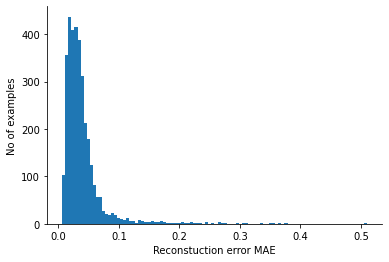

In [26]:
fig, ax = plt.subplots()
plt.hist(np.array(reconstruction_loss)[:,0], bins=100)
plt.xlabel("Reconstuction error MAE")
plt.ylabel("No of examples")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.show()

In [27]:
threshold = np.mean(np.array(reconstruction_loss)[:,0]) + 2*(np.std(np.array(reconstruction_loss)[:,0]))
print(f'Threshold: {threshold}')

Threshold: 0.10916223282248202


Choosing a theshold 2 standard deviations away from the mean of normal testing data we will determine how well such an autoencoder can classify manipulated data

In [28]:
reconstruction_loss_shuffle = []

for x, y in tqdm(test_shuffle.take(TEST_STEPS)):
  reconstruction_loss_shuffle.append(autoencoder.evaluate(x, y, verbose=0))

100%|██████████| 3375/3375 [03:36<00:00, 15.59it/s]


In [75]:
def reconstruction_plot(compatison_dataset, label, threshold):
  fig, ax = plt.subplots(figsize=(12, 6), dpi=200)
  plt.hist(np.array(reconstruction_loss)[:,0], bins=100, label='True data', alpha=0.9)
  plt.hist(np.array(compatison_dataset)[:,0], bins=100, label=label, alpha=0.9)
  plt.xlabel("Reconstuction error MAE")
  plt.ylabel("No of examples")
  ax.axvline(threshold, ls='--', c='k', alpha=0.7, label='Threshold')
  plt.grid(color='k', ls = '-.', lw = 0.25)
  ax.spines['right'].set_visible(False)
  ax.spines['top'].set_visible(False)
  _=plt.legend()

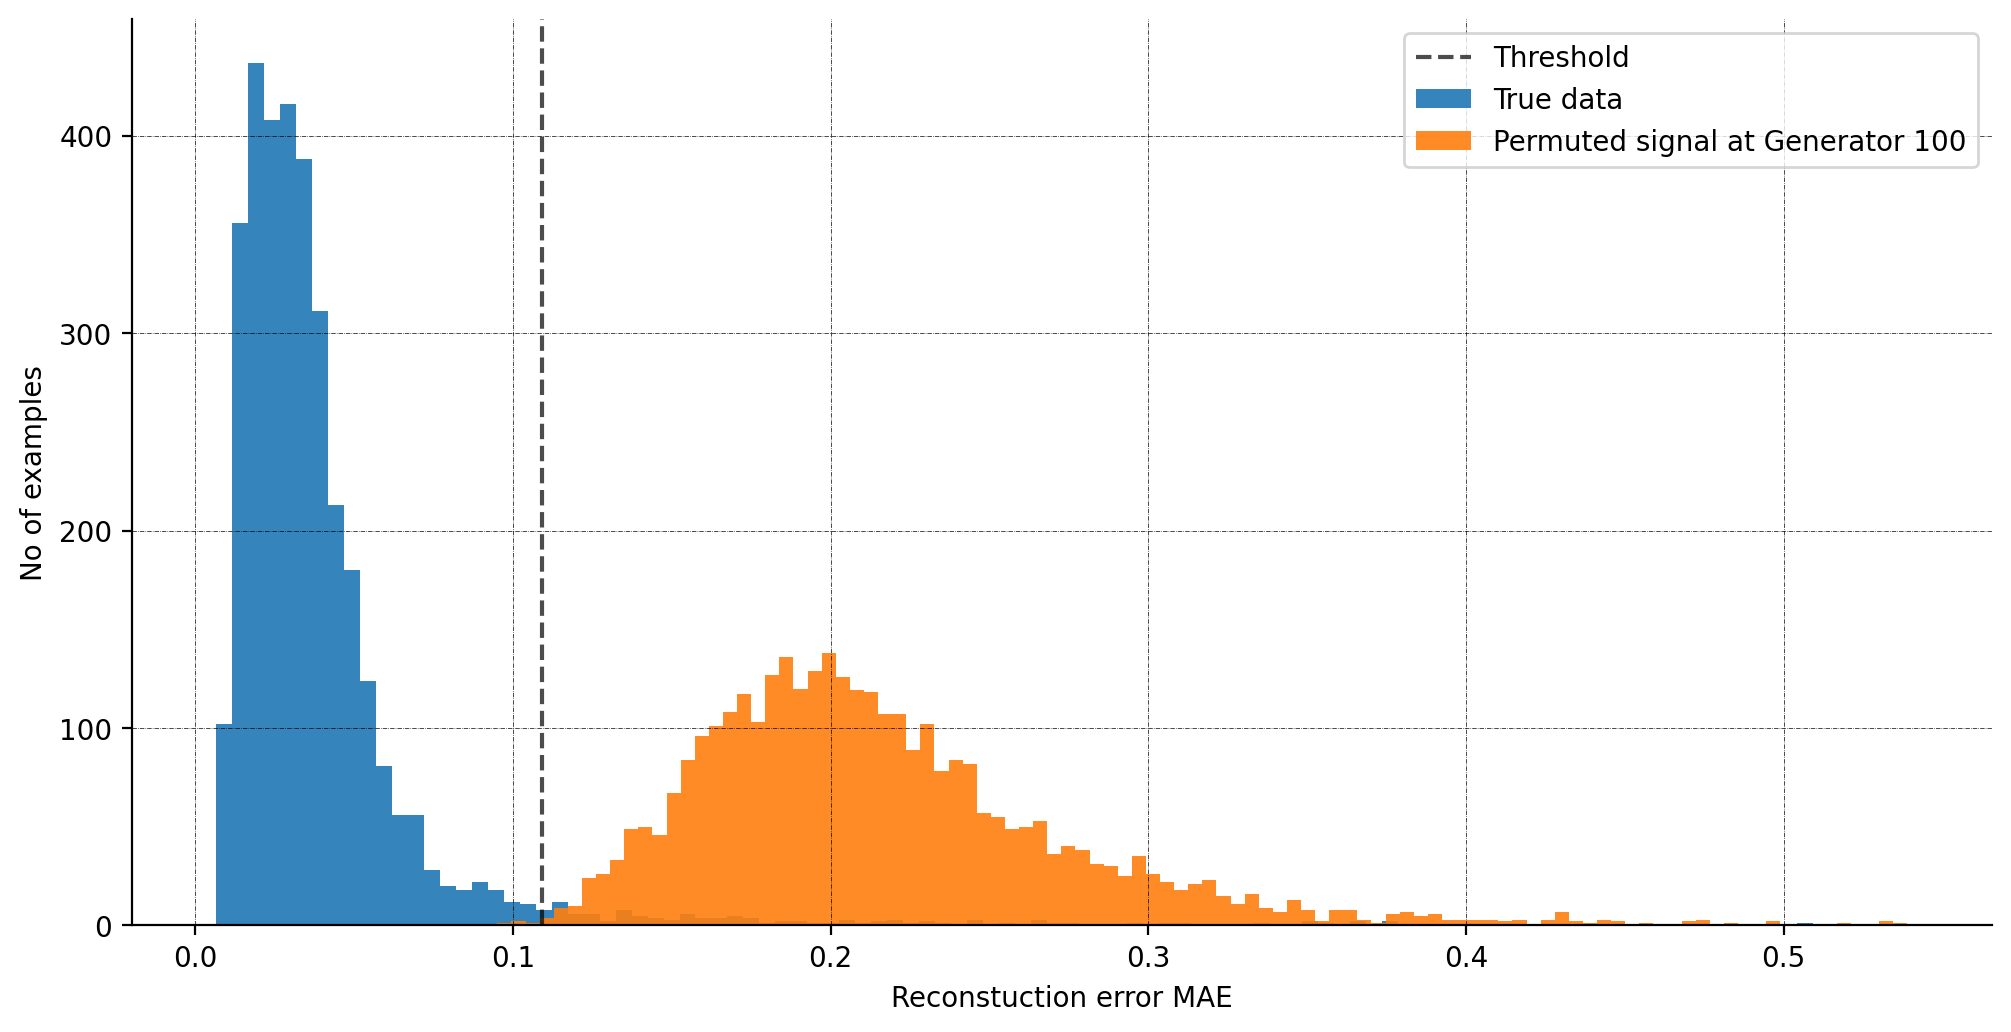

In [76]:
reconstruction_plot(reconstruction_loss_shuffle, 'Permuted signal at Generator 100', threshold)

In [48]:
preds = tf.math.less(np.array(reconstruction_loss_shuffle)[:,0], threshold)
print(f'Correctly classified manipulated sequences: {np.unique(preds.numpy(), return_counts=True)[1][0]}')
print(f'Incorrectly classified manipulated sequences: {np.unique(preds.numpy(), return_counts=True)[1][1]}')
print(f'Classification accuracy: {(np.unique(preds.numpy(), return_counts=True)[1][0]/len(reconstruction_loss_shuffle))}')

Correctly classified manipulated sequences: 3370
Incorrectly classified manipulated sequences: 5
Classification accuracy: 0.9985185185185185


Same for inverted signal

In [49]:
reconstruction_loss_invert = []

for x, y in tqdm(test_invert.take(TEST_STEPS)):
  reconstruction_loss_invert.append(autoencoder.evaluate(x, y, verbose=0))

100%|██████████| 3375/3375 [03:21<00:00, 16.76it/s]


In [72]:
threshold_invert = np.mean(np.array(reconstruction_loss)[:,0]) + 2.3*(np.std(np.array(reconstruction_loss)[:,0]))
print(f'Threshold invert: {threshold_invert}')

Threshold invert: 0.11967800865200232


In [73]:
preds_inv = tf.math.less(np.array(reconstruction_loss_invert)[:,0], threshold_invert)
print(f'Correctly classified manipulated sequences: {np.unique(preds_inv.numpy(), return_counts=True)[1][0]}')
print(f'Incorrectly classified manipulated sequences: {np.unique(preds_inv.numpy(), return_counts=True)[1][1]}')
print(f'Classification accuracy: {(np.unique(preds_inv.numpy(), return_counts=True)[1][0]/len(reconstruction_loss_invert))}')

Correctly classified manipulated sequences: 3367
Incorrectly classified manipulated sequences: 8
Classification accuracy: 0.9976296296296296


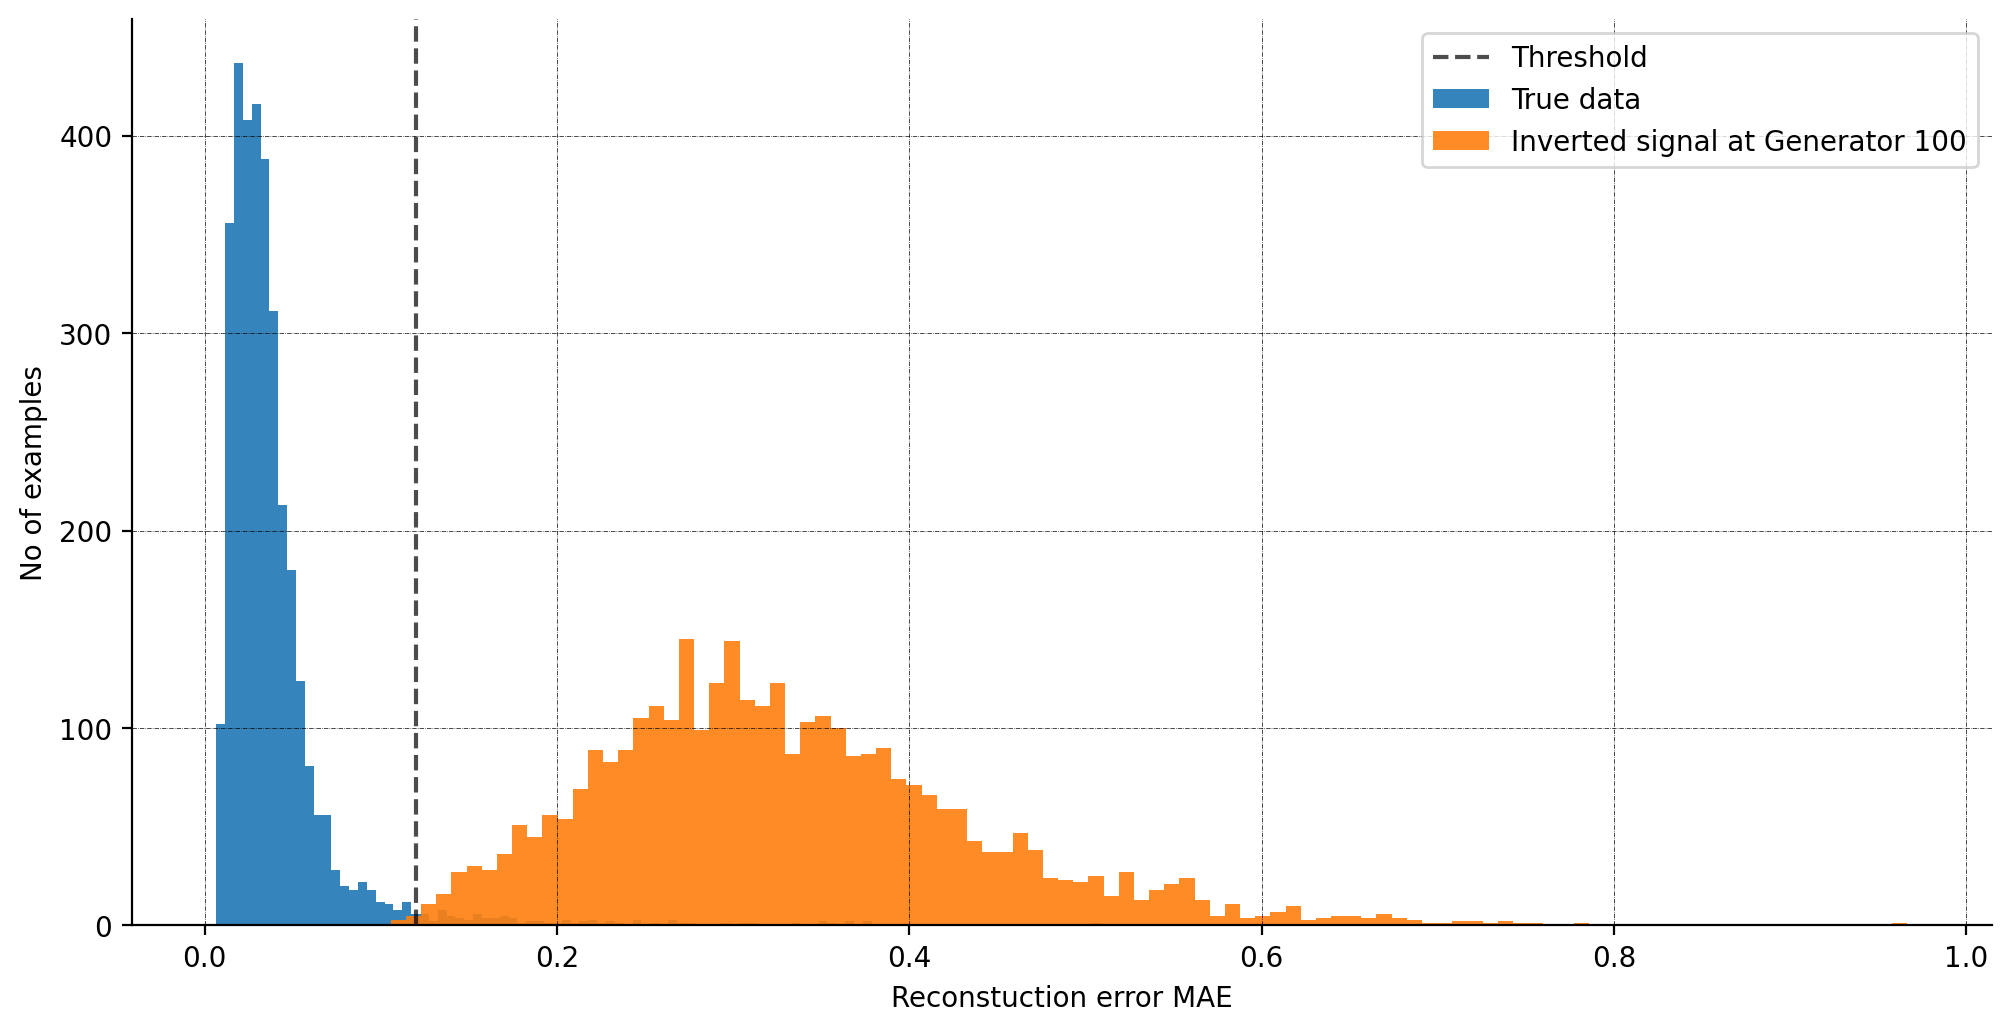

In [77]:
reconstruction_plot(reconstruction_loss_invert, 'Inverted signal at Generator 100', threshold_invert)